# Прогнозирование температуры звезды

## Описание проекта

Нам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным. В базе обсерватории есть характеристики уже изученных 240 звёзд.

## Цель проекта

В этом проекте нам необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.



## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
import random

from math import ceil, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pd.options.mode.chained_assignment = None
torch.use_deterministic_algorithms(True)

RANDOM_STATE = 12345

In [2]:
# выведем датафрейм
df = pd.read_csv('/datasets/6_class.csv', index_col=0)
display(df)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,8829,537493.000000,1423.0000,-10.73,5,White
238,9235,404940.000000,1112.0000,-11.23,5,White


In [3]:
# смотрим информацию о количестве и типе данных признаков
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


## Вывод

Датафрейм 240 на 6, названия столбцов не соответствуют PEP8.

## Предобработка и анализ данных

In [4]:
# переименуем столбцы 
df.rename(columns={
    'Temperature (K)':'temperature',
    'Luminosity(L/Lo)':'luminosity',
    'Radius(R/Ro)':'radius',
    'Absolute magnitude(Mv)':'magnitude',
    'Star type':'star_type',
    'Star color':'star_color'
}, inplace=True)
df.head(3)

,temperature,luminosity,radius,magnitude,star_type,star_color
0,3068,0.0024,0.1700,16.12,0,Red
1,3042,0.0005,0.1542,16.60,0,Red
2,2600,0.0003,0.1020,18.70,0,Red


### Признак 'star_type'

In [5]:
# выведем уникальные значения столбца 'star_type'
df['star_type'].unique()

array([0, 1, 2, 3, 4, 5])

In [6]:
# переведем признак к категориальному типу
df.star_type = df.star_type.astype('category')


### Признак 'star_color'

In [7]:
# выведем уникальные значения столбца 'star_color'
df['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [8]:
# приведем столбец к нижнему регистру и уберем лишние дефисы
df.star_color = df.star_color.str.strip()
df.star_color = df.star_color.str.lower()
df.star_color = df.star_color.str.replace('-', ' ')


In [9]:
# выведем количество значений по цвету свечения
df['star_color'].value_counts()

red                   112
blue                   56
blue white             41
white                  10
yellow white            8
yellowish               3
yellowish white         3
orange                  2
whitish                 2
pale yellow orange      1
orange red              1
white yellow            1
Name: star_color, dtype: int64

In [10]:
# уберем звезды с значениями цвета < 3 
df = df[~df['star_color'].isin(
    df.star_color.value_counts()[df.star_color.value_counts() < 3].index)]
df.reset_index(drop=True, inplace=True)

In [11]:
# поработаем с неявными дубликатами
df.star_color = df.star_color.replace('blue white', 'blue_white')
df.star_color = df.star_color.replace(['yellow white', 'white-yellow', 'yellowish', 
                                       'yellowish white'], 'yellow_white')


In [12]:
# выводим результат 
df['star_color'].value_counts()

red             112
blue             56
blue_white       41
yellow_white     14
white            10
Name: star_color, dtype: int64

In [13]:
# переведем признак к категориальному типу
df.star_color = df.star_color.astype('category')

In [14]:
print('Количество дупликатов в датафрейме:')
df.duplicated().sum()

Количество дупликатов в датафрейме:


0

In [15]:
print('Количество пропусков в датафрейме:')
display(df.isna().sum())

Количество пропусков в датафрейме:


temperature    0
luminosity     0
radius         0
magnitude      0
star_type      0
star_color     0
dtype: int64

In [16]:
# выводим основные данные по числовым признакам
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,233.0,10618.716738,9663.094823,1939.000000,3341.00000,5752.000,15680.00,40000.00
luminosity,233.0,105343.877519,175764.238630,0.000085,0.00087,0.039,198000.00,849420.00
radius,233.0,231.541959,510.587992,0.008400,0.10300,0.675,42.00,1948.50
magnitude,233.0,4.436030,10.578813,-11.920000,-6.23000,10.180,13.67,20.06


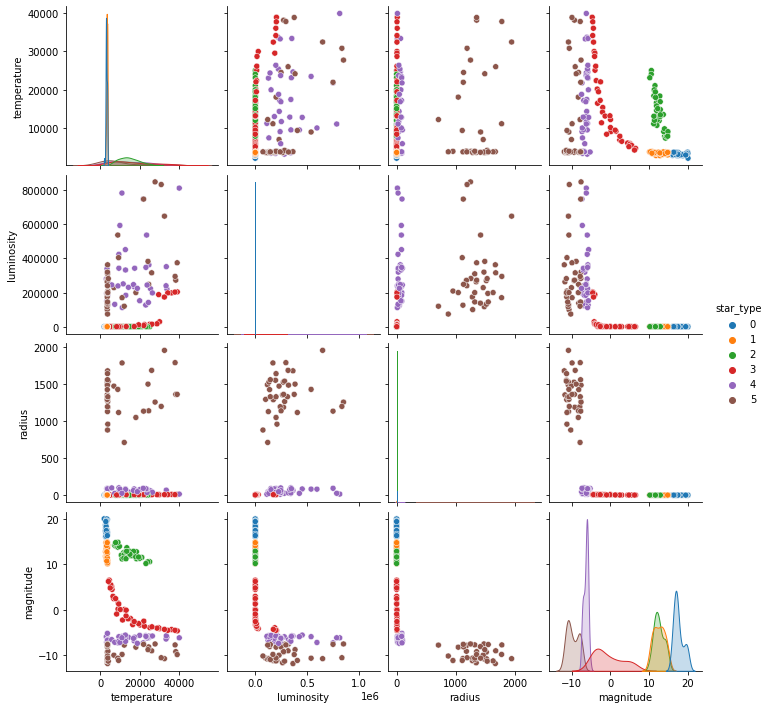

In [17]:
sns.pairplot(df, hue='star_type');

In [18]:
num = ['temperature', 'luminosity', 'radius', 'magnitude']

Хорошо видны кластеры типа звезды в зависимости абсолютной звёздой величины, с увеличением температуры начинает уменьшаться абсолютная звёздная величина.

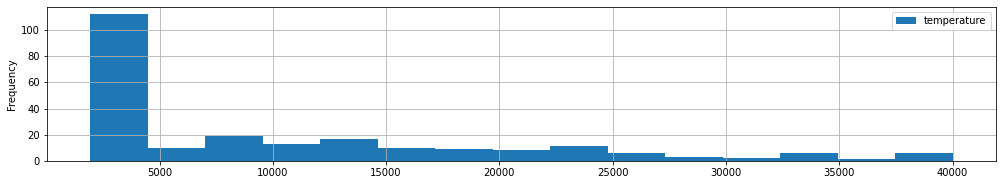

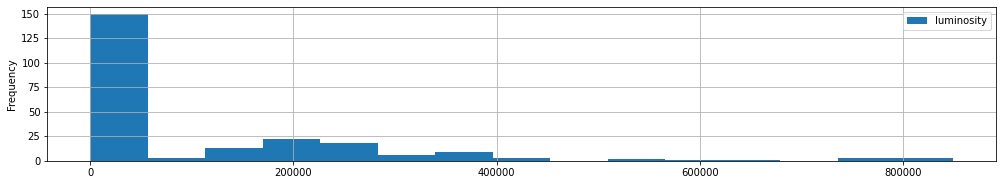

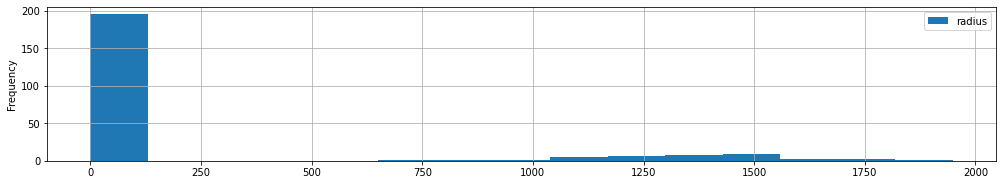

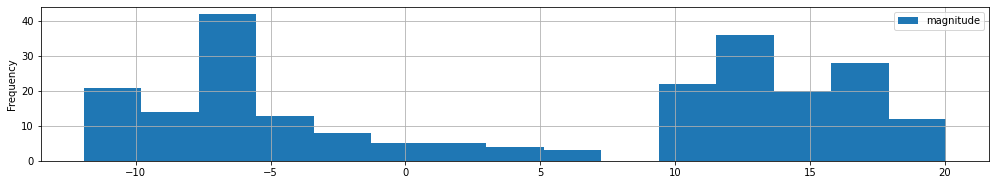

In [19]:
fig = plt.figure()
for i in range(len(num)):
    plt.subplot(len(num), 1, i+1)
    df[num[i]].plot(kind = 'hist', bins = 15, grid = True, legend = num[i], figsize = (17,13))
    plt.show()
    

Есть значения похожие на выбросы, так как данных мало, думаю не стоит в это углубляться.

In [20]:
# выведем матрицу корреляций коэффициента Пирсона по целевому признаку
df.corr()['temperature']

temperature    1.000000
luminosity     0.420789
radius         0.077383
magnitude     -0.430818
Name: temperature, dtype: float64

In [21]:
# получили следующий датафрейм
display(df.head(5))

,temperature,luminosity,radius,magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,red
1,3042,0.000500,0.1542,16.60,0,red
2,2600,0.000300,0.1020,18.70,0,red
3,2800,0.000200,0.1600,16.65,0,red
4,1939,0.000138,0.1030,20.06,0,red


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   temperature  233 non-null    int64   
 1   luminosity   233 non-null    float64 
 2   radius       233 non-null    float64 
 3   magnitude    233 non-null    float64 
 4   star_type    233 non-null    category
 5   star_color   233 non-null    category
dtypes: category(2), float64(3), int64(1)
memory usage: 8.3 KB


In [23]:
# выделяем целевой признак и признаки:
target = df["temperature"]
features = df.drop("temperature", axis=1)
num_cols = ['luminosity', 'radius', 'magnitude']
cat_cols = ['star_type', 'star_color']

In [24]:
# выделяем 70% данных для обучающей выборки, остальные данные для тестовой
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.3, shuffle=True, random_state = RANDOM_STATE)

In [25]:
for i in [features_train, features_test, target_train, target_test]:
    i.reset_index(drop=True, inplace=True)

In [26]:
# кодируем категориальные признаки:
ohe = OneHotEncoder(sparse=False, handle_unknown = 'error')

features_train_cat = pd.DataFrame(ohe.fit_transform(features_train.loc[:,cat_cols]))
features_train_cat.columns = ohe.get_feature_names(cat_cols)
features_train.drop(cat_cols, axis = 1, inplace = True)
features_train = pd.concat([features_train, features_train_cat], axis = 1)

features_test_cat = pd.DataFrame(ohe.transform(features_test.loc[:,cat_cols]))
features_test_cat.columns = ohe.get_feature_names(cat_cols)
features_test.drop(cat_cols, axis = 1, inplace = True)
features_test = pd.concat([features_test, features_test_cat], axis = 1)


In [27]:
# масштабируем числовые признаки
scaler = StandardScaler()

features_train[num_cols] = scaler.fit_transform(features_train[num_cols])
features_test[num_cols] = scaler.transform(features_test[num_cols])

In [28]:
# получили датасет готовый для построения нейросети
features_train.head(5)

,luminosity,radius,magnitude,star_type_0,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue,star_color_blue_white,star_color_red,star_color_white,star_color_yellow_white
0,-0.601107,-0.442252,0.644977,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.962052,-0.275451,-0.976110,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.601107,-0.441789,0.627111,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.601107,-0.442018,1.203519,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.601107,-0.441687,0.576335,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Вывод

В процессе предобработки изменили названия столбцов согласно PEP8, проверили данные на явные дубликаты и пропуски, избавились от неявных дубликатов. Привели типы столбцов к правильным. При помощи корреляции Пирсона выявили корреляцию числовых признаков с целевым признаком. Данные разбили на обучающую и тестовую выборку. Категорийные признаки кодировали с помощью OneHotEncoder. Масштабировали числовые признаки с помощью  StandardScaler.

## Построение базовой нейронной сети

In [29]:
# переведём наши данные к тензорам
features_train = torch.FloatTensor(features_train.values)
features_test  = torch.FloatTensor(features_test.values)
target_train  = torch.FloatTensor(target_train.values)
target_test = torch.FloatTensor(target_test.values)


In [30]:
# настраиваем количество нейронов на слоях сети
n_in_neurons = 14
n_hidden_neurons_1 = 52
n_hidden_neurons_2 = 20
n_out_neurons = 1


In [31]:
# строим нейроную сеть
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
    nn.ReLU()
)



In [32]:
# применим два оптимизатора для выбора лучшего
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adamax(net.parameters(), lr=1e-2)

loss = nn.MSELoss()


In [33]:
# функция для кросс-валидации нейронной сети
def cross_vall_score(model, features_train, target_train, optim, num_epochs=1000, batch_size=4, k=4, loss=nn.MSELoss()):
    # количество батчей 
    num_batches = ceil(len(features_train)/batch_size) 
    # размер валидационной выборки 
    num_val_samples = len(features_train)//k 
    all_scores = []
    
    for i in range(k): 
        # разбиваем на валидационную и тренировочную выборку 
        print('processing fold #', i+1, end='  ')
        
        # обнуляем веса нейронной сети
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
            
        # валидационная выборка
        val_data = features_train[i*num_val_samples: (i+1)*num_val_samples]
        val_targets = target_train[i*num_val_samples: (i+1)*num_val_samples]
        
        # тренировочная выборка
        partial_train_data = np.concatenate([features_train[:i*num_val_samples], features_train[(i+1)*num_val_samples:]], axis = 0)
        partial_train_targets = np.concatenate([target_train[:i*num_val_samples], target_train[(i+1)*num_val_samples:]], axis = 0)
        
        # приводим наши данные к формату FloatTensor
        val_data = torch.FloatTensor(val_data)
        val_targets = torch.FloatTensor(val_targets)
        partial_train_data = torch.FloatTensor(partial_train_data)
        partial_train_targets = torch.FloatTensor(partial_train_targets)
        
        for epoch in range(num_epochs):
            # создаем случайную перестановку индексов для каждой эпохи
            order = np.random.permutation(len(partial_train_data))
            
            for batch_idx in range(num_batches):
                # стартовый индекс батча
                start_index = batch_idx * batch_size
                
                # обнуляем градиаенты
                optim.zero_grad() 
                
                # извлекаем батч
                batch_indexes = order[start_index:start_index+batch_size]
                X_batch = partial_train_data[batch_indexes]
                y_batch = partial_train_targets[batch_indexes]
                
                # получаем предсказание
                preds = net.forward(X_batch).flatten() 
                
                # высчитываем ошибку
                loss_value = loss(preds, y_batch.flatten()) 
                loss_value.backward()
                optim.step()
                
            if epoch == num_epochs-1:
                model.eval()
                val_preds = model.forward(val_data)
                val_preds = val_preds.view(-1)
                RMSE_loss = torch.sqrt(loss(val_targets, val_preds))
                all_scores.append(RMSE_loss)
                print('RMSE метрика =', float(RMSE_loss))
    print('Средняя RMSE метрика =', int(sum(all_scores)/len(all_scores)))
    print(' ')
    print(' ')



In [34]:
# выведем среднее RMSE нейросети на двух оптимизаторах
x = [optimizer, optimizer2]

for i in x:
    print(i)
    cross_vall_score(net, features_train, target_train, i)
    

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 5488.97412109375
processing fold # 2  RMSE метрика = 4063.972412109375
processing fold # 3  RMSE метрика = 4577.11083984375
processing fold # 4  RMSE метрика = 3204.79736328125
Средняя RMSE метрика = 4333
 
 
Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 5587.77197265625
processing fold # 2  RMSE метрика = 3980.3544921875
processing fold # 3  RMSE метрика = 4547.025390625
processing fold # 4  RMSE метрика = 3572.829345703125
Средняя RMSE метрика = 4421
 
 


Оптимизация Adam показала себя лучше, со средней RMSE метрика = 4333

In [35]:
# проверим нейросеть на тестовой выборке
def neiron(model, features_train, target_train, optim, num_epochs=1000, batch_size=4, loss=nn.MSELoss()):
    num_batches = ceil(len(features_train)/batch_size)
    for epoch in range(num_epochs):
        order = np.random.permutation(len(features_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size 
            optim.zero_grad() 
        
            # индексы объектов текущего обатча
            batch_indexes = order[start_index:start_index+batch_size] 
            X_batch = features_train[batch_indexes]
            y_batch = target_train[batch_indexes]
        
            preds = model.forward(X_batch).flatten() 
            loss_value = loss(preds, y_batch.flatten())
            loss_value.backward()
            optim.step()
    return  model



In [36]:
# обучаем нейросеть с заданными параметрами 
net = neiron(net, features_train, target_train, optimizer2)


In [37]:
net.eval()
test_preds = net.forward(features_test)
test_preds = test_preds.view(-1)
print('RMSE нейронной сети на тестовой выборке = ', int(torch.sqrt(loss(target_test, test_preds))))



RMSE нейронной сети на тестовой выборке =  4495


In [38]:
# визуализируем предсказания нейронной сети на тестовой выборке
def vizualization(target, preds, width = 0.3):
    y1 = target.numpy().reshape([-1])
    y2 = preds.reshape([-1]).detach().numpy()
    x = np.arange(len(y1))
    
    fig,ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y1, width, label = 'Факт')
    rects2 = ax.bar(x + width/2, y2, width, label = 'Прогноз')
    ax.set_title('Факт-Прогноз')
    ax.set_xticks(x)
    ax.set_xlabel('Номер звезды в таблице данных')
    ax.set_ylabel('Температура звезды')
    fig.set_figwidth(17)
    fig.set_figheight(5)
    ax.legend();
    

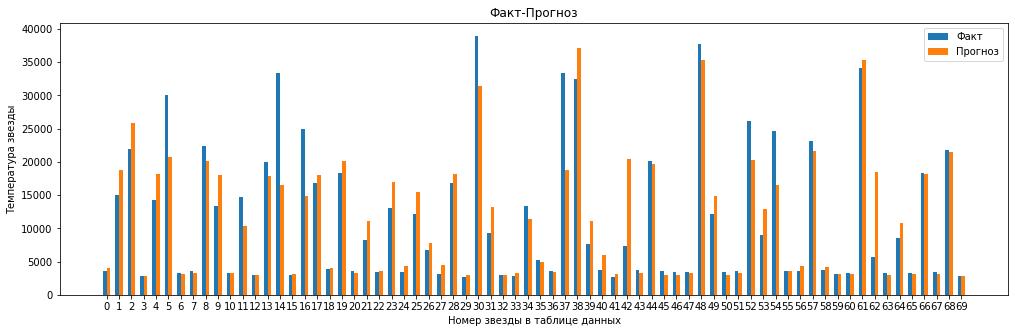

In [39]:
vizualization(target_test, test_preds)

## Вывод

Обучили нейронную сеть, использовали два оптимизатора для сравнения. RMSE нейронной сети на тестовой выборке показал значения 4495, достигли поставленной цели. Следующим шагом улучшим метрики RMSE. 
________
По результатам анализа графика "Факт-Прогноз" можно сказать что звёзды с большими абсолютными значениями температур больше 5000 градусов по Кельвину дают большую относительную ошибку, чем звёзды с малыми температурами. Для значений более 5000 градусов по Кельвину алгоритм начинает брать то выше правильного ответа, то ниже, скорее всего это связано с небольшим количеством подобных звёзд в нашей выборке, нейросеть просто не смогла правильно научиться на таком малом количестве данных.

## Улучшение нейронной сети

Для улучшения нейронной сети применим  BatchNorm и подберем несколько вариантов Dropout. 

In [40]:
# BatchNorm и Dropout(p=0.2)
class Model_1(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model_1, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dp2(x)
        x = self.fc3(x)
        
        return x 
    

In [41]:
net = Model_1(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
loss = nn.MSELoss()

optimizer2 = torch.optim.Adamax(net.parameters(), lr=1e-2)


In [42]:
# обучаем модель с заданными параметрами BatchNorm и Dropout
net = neiron(net, features_train, target_train, optimizer2)

net.eval()
test_preds = net.forward(features_test)
test_preds = test_preds.view(-1)
print('RMSE нейронной сети на тестовой выборке = ', int(torch.sqrt(loss(target_test, test_preds))))



RMSE нейронной сети на тестовой выборке =  5214


________

In [43]:
# BatchNorm и Dropout(p=0.1)
class Model_2(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model_2, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dp2(x)
        x = self.fc3(x)
        
        return x 
    

In [44]:
net = Model_2(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
loss = nn.MSELoss()

optimizer2 = torch.optim.Adamax(net.parameters(), lr=1e-2)


In [45]:
# обучаем модель с заданными параметрами BatchNorm и Dropout
net = neiron(net, features_train, target_train, optimizer2)

net.eval()
test_preds = net.forward(features_test)
test_preds = test_preds.view(-1)
print('RMSE нейронной сети на тестовой выборке = ', int(torch.sqrt(loss(target_test, test_preds))))



RMSE нейронной сети на тестовой выборке =  4972


_____

In [46]:
# BatchNorm и Dropout(p=0.5)
class Model_3(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model_3, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dp2(x)
        x = self.fc3(x)
        
        return x 
    

In [47]:
net = Model_3(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
loss = nn.MSELoss()

optimizer2 = torch.optim.Adamax(net.parameters(), lr=1e-2)


In [48]:
# обучаем модель с заданными параметрами BatchNorm и Dropout
net = neiron(net, features_train, target_train, optimizer2)

net.eval()
test_preds = net.forward(features_test)
test_preds = test_preds.view(-1)
print('RMSE нейронной сети на тестовой выборке = ', int(torch.sqrt(loss(target_test, test_preds))))




RMSE нейронной сети на тестовой выборке =  5035


_____

In [49]:
# без BatchNorm, но с Dropout(p=0.00001)
class Model_4(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model_4, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(p=0.00001)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dp2(x)
        x = self.fc3(x)
        
        return x 
    

In [50]:
net = Model_4(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
loss = nn.MSELoss()

optimizer2 = torch.optim.Adamax(net.parameters(), lr=1e-2)


In [51]:
# обучаем модель с заданными параметрами Dropout
net = neiron(net, features_train, target_train, optimizer2)

net.eval()
test_preds = net.forward(features_test)
test_preds = test_preds.view(-1)
print('RMSE нейронной сети на тестовой выборке = ', int(torch.sqrt(loss(target_test, test_preds))))




RMSE нейронной сети на тестовой выборке =  4534


Переберем батчи для улучшения метрики RMSE

In [52]:
# c 6 батчами
def neiron_6(model, features_train, target_train, optim, num_epochs=1000, batch_size=6, loss=nn.MSELoss()):
    num_batches = ceil(len(features_train)/batch_size)
    for epoch in range(num_epochs):
        order = np.random.permutation(len(features_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size 
            optim.zero_grad() 
        
            # индексы объектов текущего обатча
            batch_indexes = order[start_index:start_index+batch_size] 
            X_batch = features_train[batch_indexes]
            y_batch = target_train[batch_indexes]
        
            preds = model.forward(X_batch).flatten() 
            loss_value = loss(preds, y_batch.flatten())
            loss_value.backward()
            optim.step()
    return  model


In [53]:
net = Model_4(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
loss = nn.MSELoss()

optimizer2 = torch.optim.Adamax(net.parameters(), lr=1e-2)


In [54]:
# обучаем модель с заданными параметрами 
net = neiron_6(net, features_train, target_train, optimizer2)

net.eval()
test_preds = net.forward(features_test)
test_preds = test_preds.view(-1)
print('RMSE нейронной сети на тестовой выборке = ', int(torch.sqrt(loss(target_test, test_preds))))



RMSE нейронной сети на тестовой выборке =  4663


_______

In [65]:
# c 2 батчами
def neiron_2(model, features_train, target_train, optim, num_epochs=1000, 
              batch_size=2, loss=nn.MSELoss()):
    num_batches = ceil(len(features_train)/batch_size)
    for epoch in range(num_epochs):
        order = np.random.permutation(len(features_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size 
            optim.zero_grad() 
        
            # индексы объектов текущего обатча
            batch_indexes = order[start_index:start_index+batch_size] 
            X_batch = features_train[batch_indexes]
            y_batch = target_train[batch_indexes]
        
            preds = model.forward(X_batch).flatten() 
            loss_value = loss(preds, y_batch.flatten())
            loss_value.backward()
            optim.step()
    return  model


In [68]:
net = Model_4(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
loss = nn.MSELoss()

optimizer2 = torch.optim.Adamax(net.parameters(), lr=1e-2)


In [69]:
# обучаем модель с заданными параметрами 
net = neiron_2(net, features_train, target_train, optimizer2)

net.eval()
test_preds = net.forward(features_test)
test_preds = test_preds.view(-1)
print('RMSE нейронной сети на тестовой выборке = ', int(torch.sqrt(loss(target_test, test_preds))))



RMSE нейронной сети на тестовой выборке =  4491


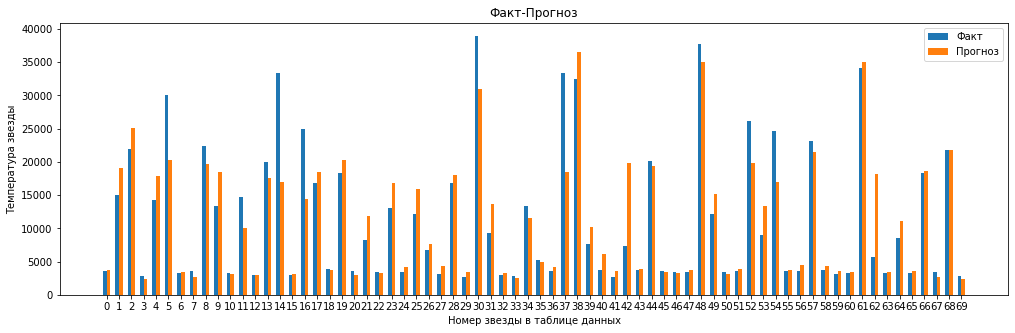

In [58]:
vizualization(target_test, test_preds)

## Выводы

В проекте выполнили предобработку и анализ данных. Обучили нейросеть. Для финальной модели использовали num_epochs=1000, batch_size=2, функцию активации в скрытых слоях Relu, функцию потерь MSELoss. Также использовали регуляризацию весов BatchNorm и Dropout. Достигли заданной метрики RMSE < 4500, с результатом 4491. Нейросеть готова к предсказанию температуры звёзд.